In [1]:
import glob
import os
import sys

import matplotlib
import matplotlib.pyplot as plt

params = {"axes.titlesize": "26", "xtick.labelsize": "20", "ytick.labelsize": "20"}
matplotlib.rcParams.update(params)

import numpy as np
import pandas as pd
import rasterio as rio

sys.path.append(os.path.join(os.path.abspath(""), "../"))
from utils.raster_utils import get_coord_from_raster
from utils.utilities import get_sample_name
from utils.io_utils import load_yaml


MASKS_ROOT = "/data"
ROI_LIST = ["1158_spring", "1868_summer", "1970_fall", "2017_winter"]
SENSOR = "lc"
METADATA_PATH = "/data/masks_metadata.csv"

val_fraction = 0.05
test_fraction = 0.05
lists_save_directory = "../config/dataset/lists"

In [2]:
metadata = pd.read_csv(METADATA_PATH, index_col=0)

In [3]:
metadata.head()

,filepath,filename,ROI,area,x0,y0,x1,y1,IGBP_9,IGBP_10,...,LCCS_SH_15,LCCS_LU_0,LCCS_LC_24,LCCS_LU_23,LCCS_SH_22,LCCS_LC_39,LCCS_LU_37,LCCS_SH_37,LCCS_LU_16,LCCS_SH_34
No,,,,,,,,,,,,,,,,,,,,,
0,/data/seg_data/ROIs1158_spring/lc_128/ROIs1158...,ROIs1158_spring_lc_128_p312,1158_spring,128,599516.364733,6.084393e+06,602076.364733,6.081833e+06,4,277,...,0,0,0,0,0,0,0,0,0,0
1,/data/seg_data/ROIs1158_spring/lc_128/ROIs1158...,ROIs1158_spring_lc_128_p514,1158_spring,128,598236.364733,6.075433e+06,600796.364733,6.072873e+06,41847,14811,...,0,0,0,0,0,0,0,0,0,0
2,/data/seg_data/ROIs1158_spring/lc_128/ROIs1158...,ROIs1158_spring_lc_128_p100,1158_spring,128,587996.364733,6.093353e+06,590556.364733,6.090793e+06,0,0,...,0,0,0,0,0,0,0,0,0,0
3,/data/seg_data/ROIs1158_spring/lc_128/ROIs1158...,ROIs1158_spring_lc_128_p101,1158_spring,128,589276.364733,6.093353e+06,591836.364733,6.090793e+06,0,0,...,0,0,0,0,0,0,0,0,0,0
4,/data/seg_data/ROIs1158_spring/lc_128/ROIs1158...,ROIs1158_spring_lc_128_p102,1158_spring,128,590556.364733,6.093353e+06,593116.364733,6.090793e+06,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
metadata["sample"] = metadata["filename"].apply(lambda x: get_sample_name(x))

### Build metadata with training labels

In [67]:
from dataset.dataset_utils import build_mask
from config.default import get_cfg_from_file
from utils.io_utils import load_yaml
from utils.raster_utils import raster_to_np
from utils.utilities import get_raster_filepath

training_cfg = get_cfg_from_file("../config/weighted_loss_less_classes_more_snow_hrnet.yml")
target_sensor_name = training_cfg.DATASET.MASK.SENSOR
mask_config = load_yaml("../" + training_cfg.DATASET.MASK.CONFIG)
class2label = mask_config["class2label"]
classes_count = len(class2label)
dataset_root = training_cfg.DATASET.ROOT

df_labels = metadata[["filepath", "sample", "ROI", "area"]]

def build_classes_df(samples_list):
    all_counts = []
    # Get target tensor
    for sample_name in samples_list:
        target_raster_path = get_raster_filepath(
            dataset_root, sample_name, target_sensor_name
        )
        target_np = raster_to_np(target_raster_path)
        transformed_mask = build_mask(target_np, mask_config)
        mask_unique = np.unique(transformed_mask, return_counts=True)
        mask_counts = np.zeros(classes_count)
        for i, count in zip(mask_unique[0], mask_unique[1]):
            mask_counts[i] = count

        all_counts.append(mask_counts)

    all_counts = np.stack(all_counts)
    df_labels_counts = pd.DataFrame(
        all_counts,
        index=samples_list,
        columns=[class2label[i] for i in range(classes_count)],
    )

    return df_labels_counts

df_labels_counts = build_classes_df(df_labels["sample"].values)

df_labels = pd.merge(df_labels, df_labels_counts, left_on="sample", right_index=True)


In [11]:
df_labels.head()

,filepath,sample,ROI,area,x0,y0,x1,y1,shrublands,urban,agricultural,barren,snow,water,dense_forest,open_forest,wetlands,grasslands
No,,,,,,,,,,,,,,,,,,
0,/data/seg_data/ROIs1158_spring/lc_128/ROIs1158...,ROIs1158_spring_128_p312,1158_spring,128,599516.364733,6.084393e+06,602076.364733,6.081833e+06,0.0,65255.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,277.0
1,/data/seg_data/ROIs1158_spring/lc_128/ROIs1158...,ROIs1158_spring_128_p514,1158_spring,128,598236.364733,6.075433e+06,600796.364733,6.072873e+06,0.0,6146.0,2732.0,0.0,0.0,0.0,0.0,41847.0,0.0,14811.0
2,/data/seg_data/ROIs1158_spring/lc_128/ROIs1158...,ROIs1158_spring_128_p100,1158_spring,128,587996.364733,6.093353e+06,590556.364733,6.090793e+06,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/data/seg_data/ROIs1158_spring/lc_128/ROIs1158...,ROIs1158_spring_128_p101,1158_spring,128,589276.364733,6.093353e+06,591836.364733,6.090793e+06,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/data/seg_data/ROIs1158_spring/lc_128/ROIs1158...,ROIs1158_spring_128_p102,1158_spring,128,590556.364733,6.093353e+06,593116.364733,6.090793e+06,0.0,65536.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
areas = df_labels.groupby(["ROI","area"]).count().index.tolist()

# shuffle
np.random.seed(10)
np.random.shuffle(areas)

val_areas = areas[:int(val_fraction*len(areas))]
test_areas = areas[int(val_fraction*len(areas)):int((val_fraction+test_fraction)*len(areas))]
train_areas = areas[int((val_fraction+test_fraction)*len(areas)):]


In [57]:
print(len(train_areas))
print(len(val_areas))
print(len(test_areas))

227
12
13


In [58]:
metadata_train = df_labels[df_labels.set_index(['ROI','area']).index.isin(train_areas)]
metadata_val = df_labels[df_labels.set_index(['ROI','area']).index.isin(val_areas)]
metadata_test = df_labels[df_labels.set_index(['ROI','area']).index.isin(test_areas)]

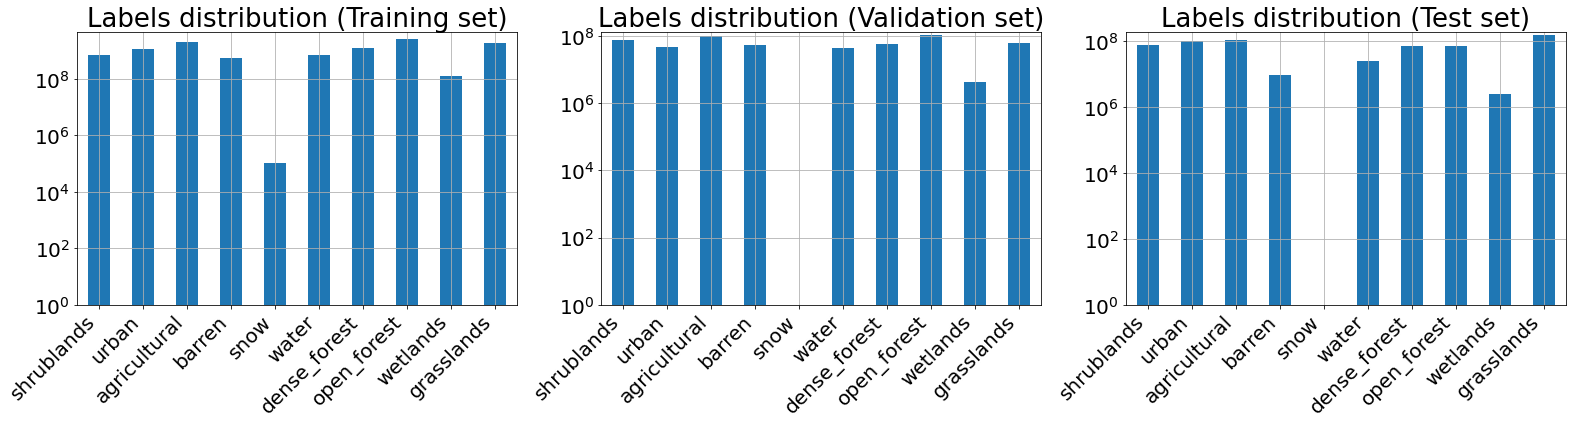

In [59]:
def plot_hists(subgrids_train, subgrids_val, subgrids_test):

    fig, ax = plt.subplots(1,3, figsize=(22,6))
    subgrids_train[list(class2label.values())].sum().plot.bar(ax=ax[0])
    subgrids_val[list(class2label.values())].sum().plot.bar(ax=ax[1])
    subgrids_test[list(class2label.values())].sum().plot.bar(ax=ax[2])
    ax[0].set_yscale("log")
    ax[1].set_yscale("log")
    ax[2].set_yscale("log")
    ax[0].set_ylim(bottom=1)
    ax[1].set_ylim(bottom=1)
    ax[2].set_ylim(bottom=1)
    ax[0].grid()
    ax[1].grid()
    ax[2].grid()
    ax[0].set_title("Labels distribution (Training set)")
    ax[1].set_title("Labels distribution (Validation set)")
    ax[2].set_title("Labels distribution (Test set)")
    fig.autofmt_xdate(rotation=45)
    plt.tight_layout()

plot_hists(metadata_train, metadata_val, metadata_test)

In [102]:
np.savetxt(os.path.join(lists_save_directory, "train.txt"), metadata_train["sample"].values, fmt="%s")
np.savetxt(os.path.join(lists_save_directory, "val.txt"), metadata_val["sample"].values, fmt="%s")
np.savetxt(os.path.join(lists_save_directory, "test.txt"), metadata_test["sample"].values, fmt="%s")

#### There is no snow in validation, let's add it

In [98]:
SNOW_ROOT="/data/seg_data/ROIs2020_snow"
all_snow_subgrids_paths = glob.glob(os.path.join(SNOW_ROOT, "lc*", "*.tif"))
all_snow_subgrids = [os.path.basename(x).split(".")[0] for x in all_snow_subgrids_paths]
all_snow_subgrids = [name.replace("_lc","") for name in all_snow_subgrids]

df_labels_snow = build_classes_df(all_snow_subgrids)
df_labels_snow["filepath"] = all_snow_subgrids_paths
df_labels_snow["ROI"] = "ROIs2020_snow"
df_labels_snow["sample"] = df_labels_snow.index
df_labels_snow["area"] = df_labels_snow["sample"].apply(lambda x: int(x.split("_")[-2]))


In [99]:
df_labels_with_snow = pd.concat([df_labels, df_labels_snow])

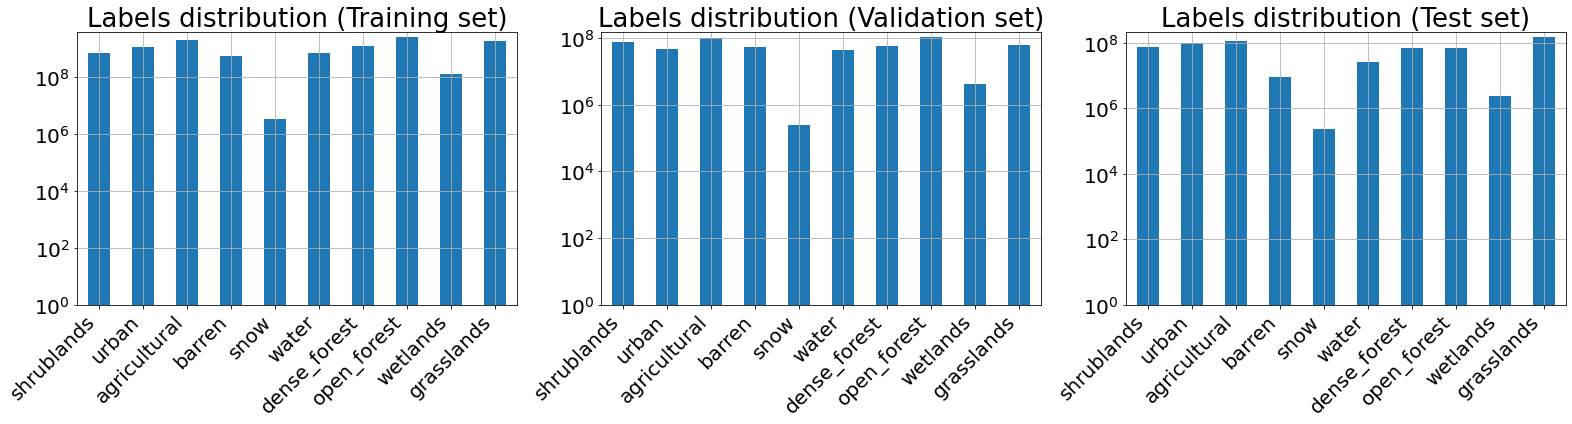

In [100]:
train_areas_with_snow = train_areas + [("ROIs2020_snow",2), ("ROIs2020_snow",3), ("ROIs2020_snow",4), ("ROIs2020_snow",5)]
val_areas_with_snow = val_areas + [("ROIs2020_snow",0)]
test_areas_with_snow = test_areas + [("ROIs2020_snow",1)]

metadata_train_with_snow = df_labels_with_snow[df_labels_with_snow.set_index(['ROI','area']).index.isin(train_areas_with_snow)]
metadata_val_with_snow = df_labels_with_snow[df_labels_with_snow.set_index(['ROI','area']).index.isin(val_areas_with_snow)]
metadata_test_with_snow = df_labels_with_snow[df_labels_with_snow.set_index(['ROI','area']).index.isin(test_areas_with_snow)]

plot_hists(metadata_train_with_snow, metadata_val_with_snow, metadata_test_with_snow)

In [53]:
print(metadata_train_with_snow.shape)
print(metadata_val_with_snow.shape)
print(metadata_test_with_snow.shape)

(161320, 21)
(9805, 21)
(9537, 21)


In [103]:
np.savetxt(os.path.join(lists_save_directory, "train_more_snow.txt"), metadata_train_with_snow["sample"].values, fmt="%s")
np.savetxt(os.path.join(lists_save_directory, "val_more_snow.txt"), metadata_val_with_snow["sample"].values, fmt="%s")
np.savetxt(os.path.join(lists_save_directory, "test_more_snow.txt"), metadata_test_with_snow["sample"].values, fmt="%s")

### Finally, let's count classes

In [104]:
counts = metadata_train_with_snow[list(class2label.values())].sum()

for i, label in enumerate(class2label.values()):
    print(f"Count for class{i} ({label}): {counts[label]}")

Count for class0 (shrublands): 673149084.0
Count for class1 (urban): 1113524136.0
Count for class2 (agricultural): 1908020469.0
Count for class3 (barren): 558323371.0
Count for class4 (snow): 3444456.0
Count for class5 (water): 705624716.0
Count for class6 (dense_forest): 1210278810.0
Count for class7 (open_forest): 2617069675.0
Count for class8 (wetlands): 123066445.0
Count for class9 (grasslands): 1767114326.0
